In [1]:
## https://cwc-project1.s3.amazonaws.com/City_envo_hpi.csv 

In [2]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# # Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,051 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,581 kB]
Get:14 http

In [3]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://cwc-project1.s3.amazonaws.com/City_envo_hpi.csv"
spark.sparkContext.addFile(url)
infile = spark.read.csv(SparkFiles.get("City_envo_hpi.csv"), sep=",", header=True, inferSchema=True)

In [5]:
# Show DataFrame
infile.show()

+----------+----------+---------+----------+-------------------+--------------+---------+-----------------+------+-------+------------+--------------+------+------------------+-----------+------------+------------+--------+-----------+----------+------------+------------+--------------+------------+------------+------------+------------+--------------+------------+------------+------------------+----------+------+-------------------+------+-----------------+-----------------+---------+-----------------+-----------------+---------+-------+
|stateabbr0| placename|placefips| tractfips|     place_tractid4|population2010|insurance|highbloodpressure|cancer|asthma9|heartdisease|annualcheckups|smokes|mentalhealthissues|   latitude|   longitude|countyfips16|   State|StateAbbr18|    County|CountyFIPS20|    Asthma21|AFHeartDisease|        COPD|  Depression|HeartFailure|Hypertension|CoronaryArtery|   Psychotic|      Stroke|         TotalCost|     tract|   hpi|    Place_TractID33|SiteId|PM2.5_Excep

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
df = infile.toPandas()
df.head()

,stateabbr0,placename,placefips,tractfips,place_tractid4,population2010,insurance,highbloodpressure,cancer,asthma9,...,hpi,Place_TractID33,SiteId,PM2.5_Exceptional,PM2.5_ExceedCount,PM2.5_Max,Ozone_Exceptional,Ozone_ExceedCount,Ozone_Max,sfcount
0,AL,Birmingham,107000,1073003200,0107000-01073003200,931,26.8,57.0,6.0,14.4,...,147.35,0107000-01073003200,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0
1,AL,Birmingham,107000,1073003300,0107000-01073003300,947,21.4,55.2,6.8,12.9,...,211.99,0107000-01073003300,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0
2,AL,Birmingham,107000,1073010500,0107000-01073010500,114,23.9,60.5,7.1,13.6,...,167.48,0107000-01073010500,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0
3,AL,Birmingham,107000,1073010701,0107000-01073010701,74,19.8,24.9,2.7,11.2,...,670.86,0107000-01073010701,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0
4,AL,Birmingham,107000,1073010801,0107000-01073010801,168,7.3,33.0,7.4,8.9,...,607.68,0107000-01073010801,11.0,0.0,0.0,26.6,0.0,1.0,0.078,1.0


In [8]:
median_hpi = df['hpi'].median()
print(median_hpi)

391.08000000000004


In [9]:
performance = []
for value in df['hpi']:
    if value >= median_hpi:
        performance.append('Overperforming')
    else:
        performance.append('Underperforming')
df['Performance'] = performance
df.head(10)

,stateabbr0,placename,placefips,tractfips,place_tractid4,population2010,insurance,highbloodpressure,cancer,asthma9,...,Place_TractID33,SiteId,PM2.5_Exceptional,PM2.5_ExceedCount,PM2.5_Max,Ozone_Exceptional,Ozone_ExceedCount,Ozone_Max,sfcount,Performance
0,AL,Birmingham,107000,1073003200,0107000-01073003200,931,26.8,57.0,6.0,14.4,...,0107000-01073003200,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Underperforming
1,AL,Birmingham,107000,1073003300,0107000-01073003300,947,21.4,55.2,6.8,12.9,...,0107000-01073003300,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Underperforming
2,AL,Birmingham,107000,1073010500,0107000-01073010500,114,23.9,60.5,7.1,13.6,...,0107000-01073010500,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Underperforming
3,AL,Birmingham,107000,1073010701,0107000-01073010701,74,19.8,24.9,2.7,11.2,...,0107000-01073010701,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Overperforming
4,AL,Birmingham,107000,1073010801,0107000-01073010801,168,7.3,33.0,7.4,8.9,...,0107000-01073010801,11.0,0.0,0.0,26.6,0.0,1.0,0.078,1.0,Overperforming
5,AL,Birmingham,107000,1073010802,0107000-01073010802,172,6.6,37.2,11.2,8.4,...,0107000-01073010802,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Overperforming
6,AL,Birmingham,107000,1073010803,0107000-01073010803,514,12.5,31.7,5.7,9.9,...,0107000-01073010803,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Overperforming
7,AL,Birmingham,107000,1073010805,0107000-01073010805,86,9.7,49.6,7.8,9.8,...,0107000-01073010805,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Overperforming
8,AL,Birmingham,107000,1073011207,0107000-01073011207,815,19.2,39.3,4.6,12.7,...,0107000-01073011207,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Underperforming
9,AL,Birmingham,107000,1073011803,0107000-01073011803,928,20.9,42.1,5.1,12.9,...,0107000-01073011803,11.0,0.0,0.0,26.6,0.0,1.0,0.078,0.0,Underperforming


<Axes: >

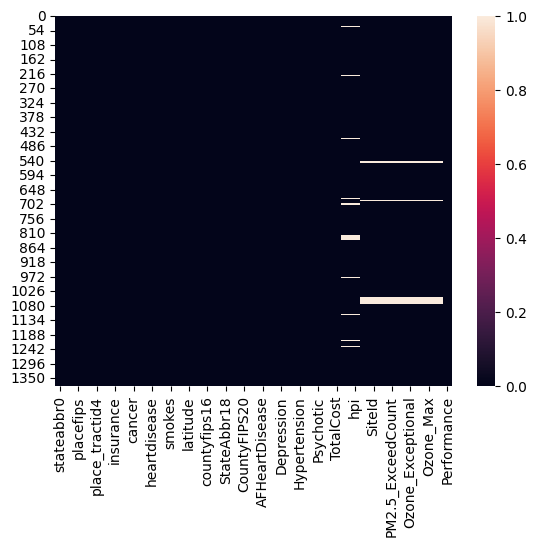

In [10]:
import seaborn as sns
sns.heatmap(df.isnull())

In [11]:
df2 = df.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 0 to 1377
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stateabbr0          1279 non-null   object 
 1   placename           1279 non-null   object 
 2   placefips           1279 non-null   int32  
 3   tractfips           1279 non-null   int64  
 4   place_tractid4      1279 non-null   object 
 5   population2010      1279 non-null   int32  
 6   insurance           1279 non-null   float64
 7   highbloodpressure   1279 non-null   float64
 8   cancer              1279 non-null   float64
 9   asthma9             1279 non-null   float64
 10  heartdisease        1279 non-null   float64
 11  annualcheckups      1279 non-null   float64
 12  smokes              1279 non-null   float64
 13  mentalhealthissues  1279 non-null   float64
 14  latitude            1279 non-null   float64
 15  longitude           1279 non-null   float64
 16  county

In [12]:
feature_cols = ['highbloodpressure','cancer','asthma9','heartdisease','mentalhealthissues','insurance','smokes'] 
X = df2[feature_cols]
y = df2.Performance

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y)

In [14]:
logreg = LogisticRegression(random_state=42)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.73125


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[123  38]
 [ 48 111]]


In [17]:
report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

 Overperforming       0.72      0.76      0.74       161
Underperforming       0.74      0.70      0.72       159

       accuracy                           0.73       320
      macro avg       0.73      0.73      0.73       320
   weighted avg       0.73      0.73      0.73       320



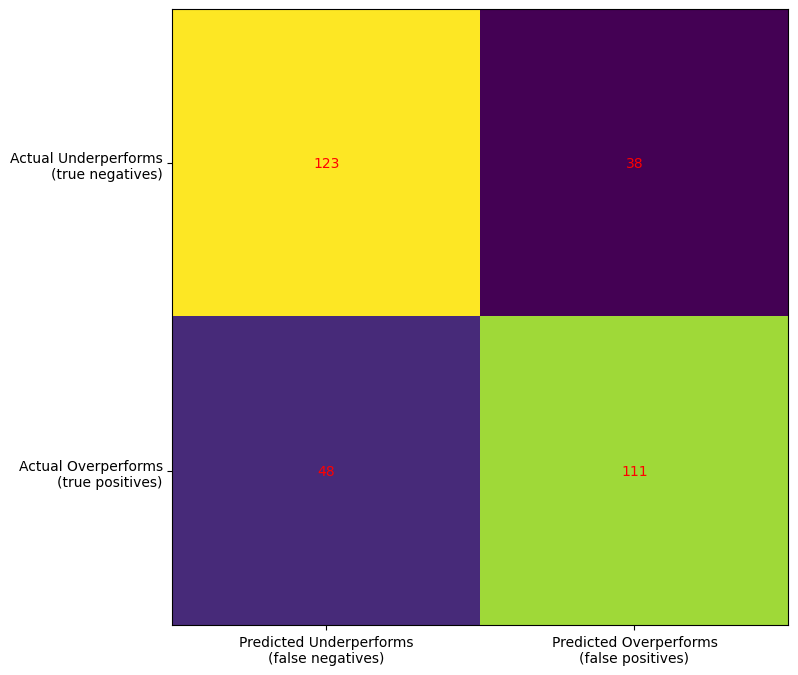

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(matrix)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Underperforms\n(false negatives)', 'Predicted Overperforms\n(false positives)'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Underperforms\n(true negatives)', 'Actual Overperforms\n(true positives)'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, matrix[i, j], ha='center', va='center', color='red')
plt.show()

In [20]:
logreg.classes_

array(['Overperforming', 'Underperforming'], dtype=object)

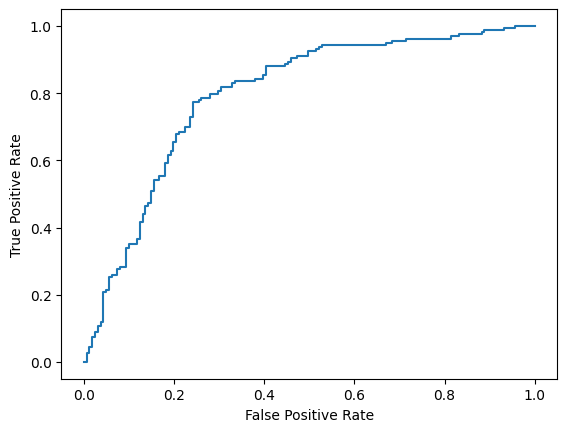

In [21]:
from sklearn import metrics
y_test = y_test.map({'Underperforming': 1, 'Overperforming': 0}).astype(int)
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [22]:
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)

0.7951873120043751
